<a href="https://colab.research.google.com/github/rmr327/TCAV_Hypo_Test/blob/main/TCAV_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis Testing with Testing Concept Activation Vectors (TCAV)

..Gemini was used for code compltetion in some places.

..Microsoft Copilot was used instead of google to ask questions.

> This notebook was adapted from https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb#scrollTo=0aF2hXJ_dNet

>H0: The GoogleNet model does not show a significant difference in its ability to learn the concept "striped" compared to random concepts for the class ‘zebra’.

>H1: The GoogleNet model shows a significant difference in its ability to learn the concept "striped" compared to random concept for the class ‘zebra’, specifically, it learns the concept "striped" but not the concept "dotted".

To perform this hypothesis testing we can use the concept of TCAV. Using TCAV allows for a detailed and interpretable analysis of how specific concepts influence a model’s predictions. In short, TCAV scores measure the sisnsitivity of a models prediction to a specifict concept. TCAV helps in quantifying human-understanable conepts on a model's predections.

TCAV scores across multiple experiments can then be used to perform a two-sided t-test. The two-sided t-test offers a solid statistical approach to determine whether the differences in TCAV scores are significant, making sure the results are both trustworthy and insightful.

Furhtermore, we can calculate the 95% confidence interval of the TCAV score difference between striped and random to get more evidence for out hypothesis testing.

## Experiment Design:

1) Download sample datasets using github download_and_make_dataset.py
  >This step ensures we have enough data to perform 10 random experiments (Recommended to do >= 10).

2) Calculate TCAV scores of the concept class (Striped) and random for each of the 10 experiments. Each experiment is done with the same concept (i.e. striped) dataset, but a different random dataset. Multiple experiments help control for randomness, robustness and reliability.

3) Since all the conditions for a two-sided t-test are met, apply a two-sided t-test to the 10 TCAV scores against the 10 TCAV scores generated by the random convecepts. Interpret the results to assess the hupothesis.


## Downloading the data

In [19]:
# We are going to clone the tcav repo in GitHub:
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=YOUR_FOLDER --number_of_images_per_folder=10 --number_of_random_folders=10

%cd /content/tcav

fatal: destination path 'tcav' already exists and is not an empty directory.
/content/tcav/tcav
activation_generator.py  cav_test.py	       model.py       tcav_examples  utils_plot.py
activations		 inception5h	       model_test.py  tcav.py	     utils.py
cav.py			 __init__.py	       __pycache__    tcav_results   utils_test.py
cavs			 mobilenet_v2_1.0_224  run_params.py  tcav_test.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Downloaded 10 for zebra
Successfully created data at YOUR_FOLDER
/content/tcav


<Figure size 640x480 with 0 Axes>

## Installing & Loading Libraries

In [20]:
!pip install tcav matplotlib==2.2.4 Pillow==8.2.0 scikit-learn==0.20.3 scipy==1.2.1 tensorflow==2.14.1 numpy==1.19.2 protobuf==3.10.0 pandas==1.0.3

  Using cached tcav-0.2.2-py3-none-any.whl.metadata (4.4 kB)
  Using cached matplotlib-2.2.4.tar.gz (37.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached Pillow-8.2.0.tar.gz (47.9 MB)
  Preparing metadata (setup.py) ... done
  Using cached scikit-learn-0.20.3.tar.gz (11.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.2.1.tar.gz (23.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached numpy-1.19.2.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error w

In [62]:
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot
import numpy as np
import scipy.stats


## Curate data & shelf data

In [22]:
# From reference
# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'zebra'
concepts = ["striped"]

In [23]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_

In [24]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' -> '/content/tcav/tcav/inception5h/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h': Is a directory


## Example Data from the dataset

Images from target folder:


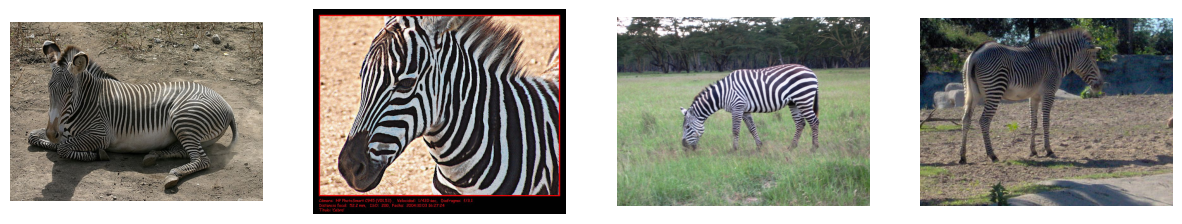

Images from striped folder:


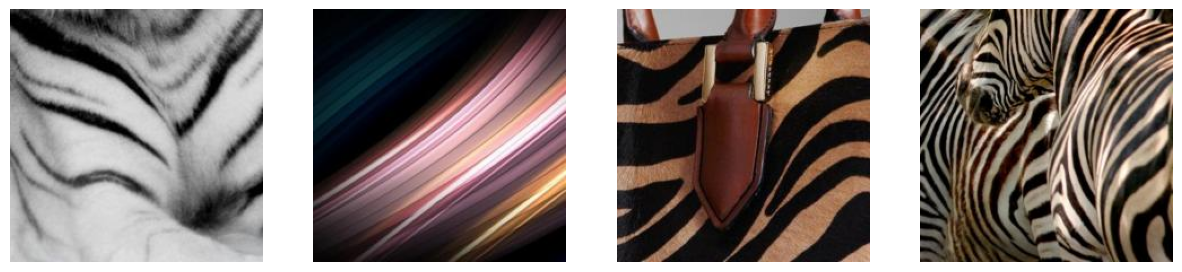

Images from random folder:


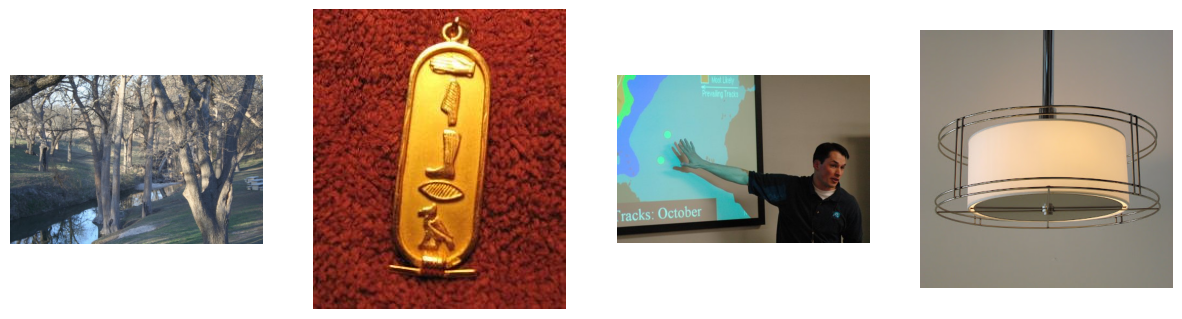

In [25]:
# From reference
def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Define source directory
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
target = 'zebra'
concepts = ["striped"]
random_folder = 'random500_9'

# Display 3 images from the target folder in a row
print("Images from target folder:")
display_random_images(os.path.join(source_dir, target), 4)

# Display 3 images from each concept folder
for concept in concepts:
    print(f"Images from {concept} folder:")
    display_random_images(os.path.join(source_dir, concept), 4)

# Display 3 images from a random folder
print("Images from random folder:")
display_random_images(os.path.join(source_dir, random_folder), 4)


# Prepaer Model Wrapper

In [26]:
sess = utils.create_session() # a tensorflow session

# trained model path
GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
# Labels path
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


## Get activations from chosen layer to compute TCAV scores

In [27]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

In [28]:
absl.logging.set_verbosity(0)
num_random_exp=10 # Recommend >10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started
Completed


# Perform 2-sided t test for evidence against Null Hypothesis

Class = zebra
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.82 (+- 0.16), random was 0.53 (+- 0.25). p-val = 0.000 (significant)
{'mixed4c': {'bn_vals': [0.825], 'bn_stds': [0.16007810593582122], 'significant': [True]}}


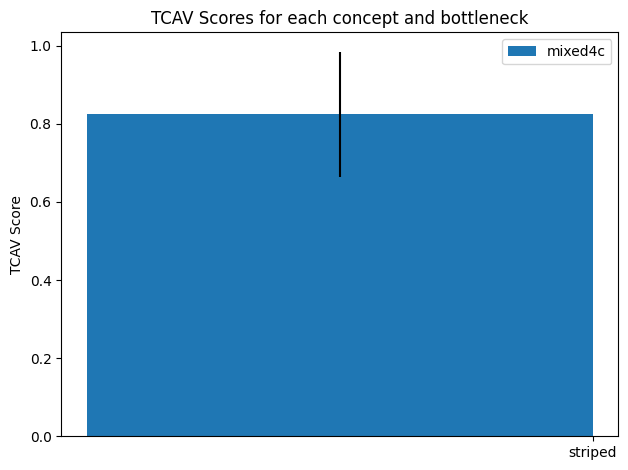

In [29]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

The above results show a significantly higher TCAV score for our concept class "Striped" as opposed to radom. This is statistically confirmed by lookin at the calculated p-value. Since the P-value obtained from the two-sided t-test (0.00) is smaller than our significance level of 0.01, we can reject the null hypothesis. We have enough evidence to reject the claim that GoogleNet model does not show a significant difference in its ability to learn the concept "striped" compared to random concepts for the class ‘zebra’. This suggests evidence towards the alternative hypothesis.

To get even more evidence towards our alternative hypothesis. we can calculate the 90% confidence interval of the mean difference in accuracy between the striped and random conceptrs achieved from each experiment.

## Calculate 95% Confidence interval to find proof for alternative hypothesis.

In [79]:
striped_cav_accuracies = [r['cav_accuracies']['striped'] for r in results[:10]]
random_cav_accuracies = [r['cav_accuracies'][r['negative_concept']] for r in results[:10]]

strped_rand_cav_acc_diff = [abs(s - r) for s, r in zip(striped_cav_accuracies,
                                                  random_cav_accuracies)]

mean_diff = sum(strped_rand_cav_acc_diff) / len(strped_rand_cav_acc_diff)
mean_diff_std_error = np.std(strped_rand_cav_acc_diff) / \
np.sqrt(len(strped_rand_cav_acc_diff))

# confidence_interval = (mean_diff - scipy.stats.t.ppf(0.975, 9) * mean_diff_std_error,
#                        mean_diff + scipy.stats.t.ppf(0.975, 9) * mean_diff_std_error)

confidence_interval = (mean_diff - scipy.stats.t.ppf(0.95, 9) * mean_diff_std_error,
                       mean_diff + scipy.stats.t.ppf(0.95, 9) * mean_diff_std_error)

print('90% Confidence Interval for differnce in accuracy between Striped & Random concepts:',
      confidence_interval)

90% Confidence Interval for differnce in accuracy between Striped & Random concepts: (0.12247586547416764, 0.5108574678591659)


Based on the above results we can be 90% confident that the true difference in mean accuracy (striped vs random concepts) lies between 12.24% & 51.09%. Since the lower bound is significantly above 0, we can conclude that we have enough evidence to support our alternative hypothesis.

> **NOTE**: With only 10 data points, our confidence interval might be less precise. Using the t-distribution instead of the normal distribution, accounts for smaller sample sizes. Yet Confidence Intervals with smaller sample sizes may not the most robust.

## Summary of fidnings

The results from this studty indicate significantly higher TCAV score for our concept class "Striped" as opposed to radom. This is statistically confirmed by lookin at the calculated p-value less than our chosen significance level. We uncovered enough evidence to reject the claim that GoogleNet model does not show a significant difference in its ability to learn the concept "striped" compared to random concepts for the class ‘zebra’.

Furthermore, we can be 90% confident that the true difference in mean accuracy (striped vs random concepts) lies between 12.24% & 51.09%. Since the lower bound of our calculaed confidence interval is significantly above 0, we can conclude that we have enough evidence to support our alternative hypothesis.